# Statistical issues in naive calibration analyses

The statistical problem of calibrating a sample with observable pairs $\hat a$ and $\hat b$ is challenging if random stochastic fluctuations affect both numbers of the pair. Even if the unknown true values $(a, b)$ have a perfectly linear relationship and if the stochastic fluctuations around $(a, b)$ are symmetric, a binned profile of the $\hat b$ values as a function of the $\hat a$ values may indicate a departure from a linear dependence. This happens if the stochastic fluctuations of $\hat a$ around $a$ are not negligible compared to the bin size.

We demonstrate this in the following with toy simulation. We assume fluctuations that are relative to the true values and that the true pairs $(a,b)$ are not uniformly distributed, but follow an exponential distribution. This is commonly the case in particle physics.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.194 (χ²/ndof = 0.5)      │              Nfcn = 31               │
│ EDM = 1.42e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

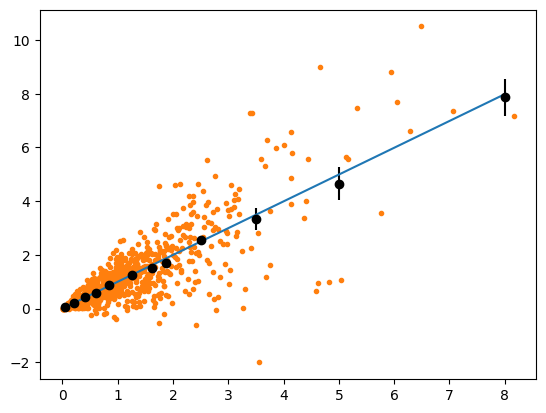

In [60]:
import numpy as np
from matplotlib import pyplot as plt
import boost_histogram as bh
from iminuit import Minuit
from iminuit.cost import LeastSquares

rng = np.random.default_rng(1)

x_true = rng.exponential(1, size=1000)
# x_true = rng.uniform(0, 10, size=1000)
y_true = x_true.copy()

def sigma_x(x_true):
    return x_true * 0.1

def sigma_y(y_true):
    return y_true * 0.5

x = rng.normal(x_true, sigma_x(x_true))
y = rng.normal(y_true, sigma_y(y_true))

h = bh.Histogram(bh.axis.Variable([0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 1.75, 2, 3, 4, 6, 10]), storage=bh.storage.Mean())
h.fill(x, sample=y)

def line(x, a, b):
    return a + x * b

m = Minuit(LeastSquares(h.axes[0].centers, h.values(), h.variances() ** 0.5, line), 0, 0)
m.migrad()

plt.scatter(x, y, marker=".", color="C1")
m.visualize()
print(m)

We find excellent linearity, the fitted line is compatible with zero offset and a slope of one.

Now we swap the roles of `x` and `y` and perform the exact same analysis again. An analysis based on a profile is not treating `x` and `y` symmetrically, therefore it is possible that we get another answer, although fundamentally it does not matter whether we study pairs `(x, y)` or `(y, x)`.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8884 (χ²/ndof = 888.4)     │              Nfcn = 35               │
│ EDM = 1.01e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

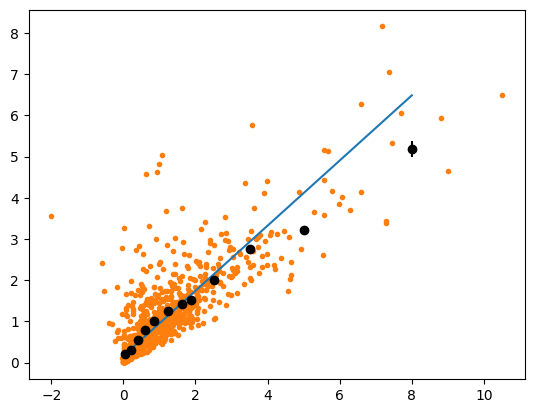

In [65]:
x, y = y, x

h = bh.Histogram(bh.axis.Variable([0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 1.75, 2, 3, 4, 6, 10]), storage=bh.storage.Mean())
h.fill(x, sample=y)

m = Minuit(LeastSquares(h.axes[0].centers, h.values(), h.variances(), line), 0, 0)
m.migrad()

plt.scatter(x, y, marker=".", color="C1")
m.visualize()
print(m)

Both eye inspection and the fit indicate that the data is not linear, although it actually is. This surprising result is obtained even though the fluctuations in both `x` and `y` are symmetric around the true value. It originates from bin migration effects, which are not taken into account in this simple study.

It is possible to avoid the bias with a more sophisticated analysis that properly treats this problem with the maximum likelihood method. Such an analysis was developed to calibrate the Pierre Auger Observatory, which can be transferred to other calibration problems.

[H. Dembinski, B. Kégl, I.C. Maris, M. Roth, D. Veberič, Astropart.Phys. 73 (2016) 44-51](https://inspirehep.net/literature/1357170)

If the proper likelihood analysis of the problem cannot be performed, one should always bin in the variable which depicts smaller fluctuations and try to make the bins large compared to these fluctuations to minimize bin migration. However, this can also be counter-productive as making bins larger increases another bias from mixing samples that have locally different expectation values and densities.

Even then, however, it is not guaranteed that biases are absent. This needs to confirmed with toy simulations.

If the extra effort needed to patch up a naive analysis is included, the amount of work is as great or larger to using the proper likelihood analysis described in the paper, which makes the likelihood analysis the economic choice.